In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from utils.visualization import visualize_rel_error_report
from utils.data import (
    DATA_SOURCE,
    PROC_SOURCE,
    PRED_SINK,
    MODEL_SINK,
    EXP_CSV_COLS,
    EXP_CSV_PATH,
    TRIALS_CSV_COLS,
    TRIALS_CSV_PATH,
)

VAL_SOURCE = DATA_SOURCE.parent / "validation"

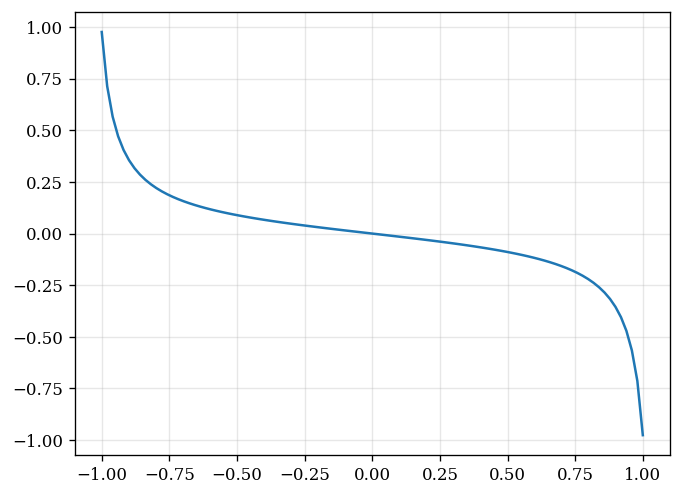

In [2]:
# new ts feature: Closeness to B max
x = np.linspace(-1, 1, 100)
plt.plot(x, -np.tan(0.9*np.tan(x))/6)

# Demonstrate Error Report as requested by Competition hosts

In [3]:
ds = pd.read_pickle(PROC_SOURCE / f"ten_materials.pkl.gz")
ds.head()

,B_t_0,B_t_1,B_t_2,B_t_3,B_t_4,B_t_5,B_t_6,B_t_7,B_t_8,B_t_9,...,H_t_1015,H_t_1016,H_t_1017,H_t_1018,H_t_1019,H_t_1020,H_t_1021,H_t_1022,H_t_1023,material
0,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,0.000605,0.000798,0.000991,0.001183,...,-0.068580,-0.006417,0.018589,0.058047,0.116027,0.146445,0.205559,0.246783,0.282453,3C94
1,-0.003780,-0.003564,-0.003349,-0.003134,-0.002919,-0.002704,-0.002488,-0.002273,-0.002057,-0.001841,...,-0.746571,-0.671371,-0.632159,-0.561076,-0.498503,-0.454116,-0.415671,-0.343287,-0.295710,3C94
2,-0.000511,-0.000267,-0.000022,0.000222,0.000466,0.000711,0.000955,0.001199,0.001443,0.001687,...,0.071388,0.118316,0.198280,0.242493,0.304861,0.348796,0.424903,0.491380,0.532922,3C94
3,0.000458,0.000732,0.001007,0.001281,0.001555,0.001830,0.002104,0.002378,0.002653,0.002927,...,0.423018,0.480285,0.537155,0.602214,0.659522,0.700088,0.773543,0.842442,0.916033,3C94
4,-0.000040,0.000269,0.000578,0.000888,0.001198,0.001507,0.001816,0.002125,0.002433,0.002740,...,0.331040,0.435295,0.471087,0.552306,0.594743,0.637451,0.735692,0.808370,0.918806,3C94


In [2]:
preds = pd.read_csv(PRED_SINK / "CNN_H_preds_16-Sep-2023_06:55_Uhr_score_2.86.csv.zip", dtype={'material': str})
preds.head()


FileNotFoundError: [Errno 2] No such file or directory: '/home/wk/dev/projects/magnet-challenge-2023/data/output/CNN_H_preds_16-Sep-2023_06:55_Uhr_score_2.86.csv.zip'

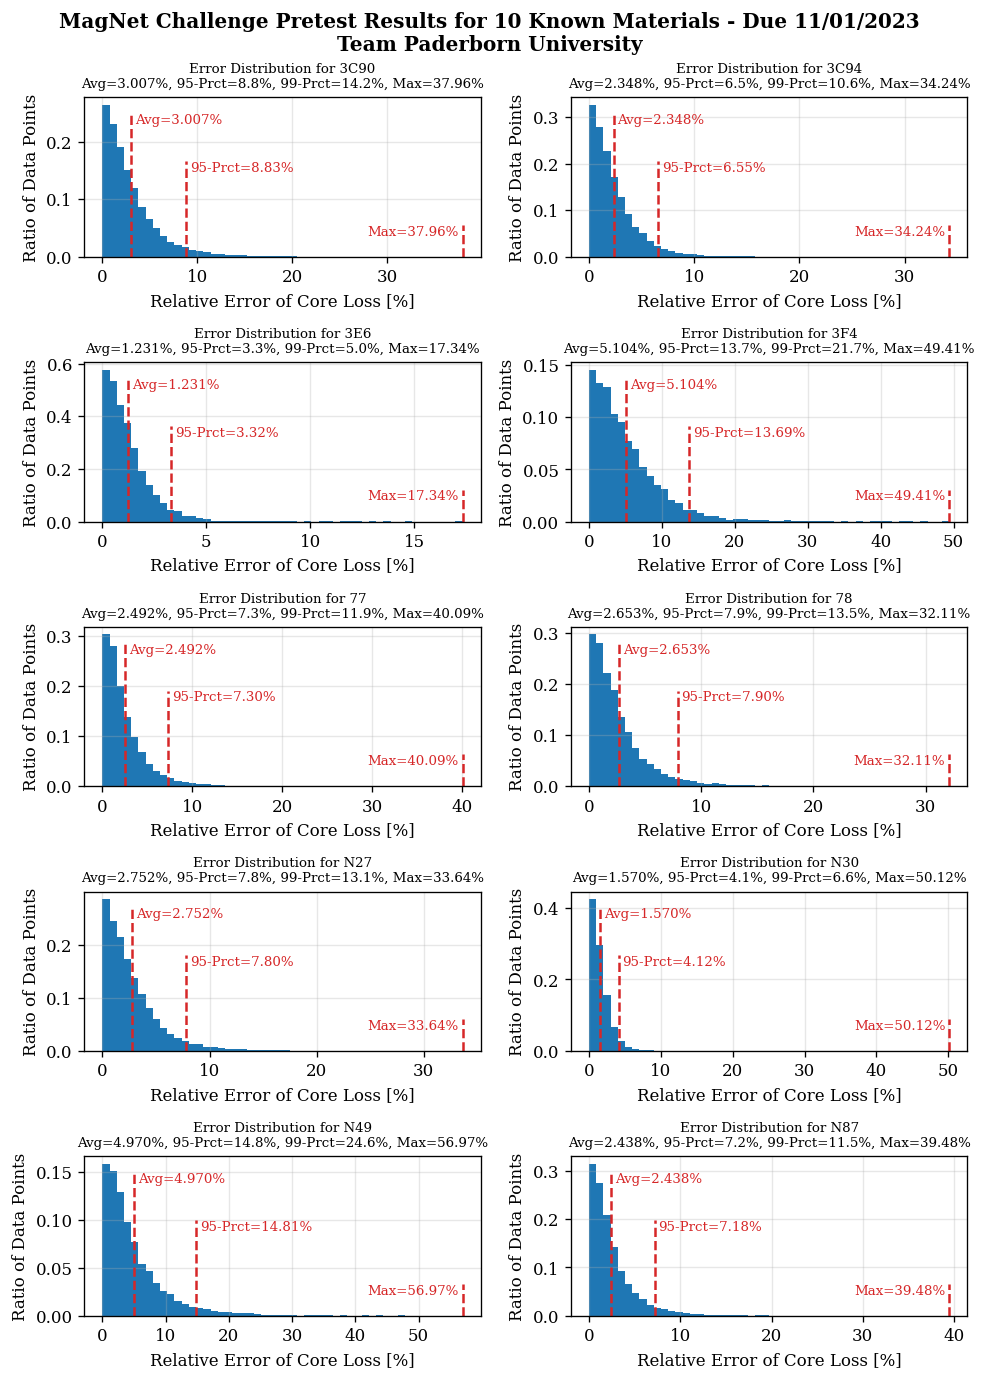

In [8]:
fig = visualize_rel_error_report(preds, ds)
fig.savefig(PRED_SINK.parent.parent / 'docs' / "error_report.pdf", dpi=300, bbox_inches='tight')

# Create Visuals for validation data (due first Nov. 2023)
By loading a trained model and execute on the validation data

In [10]:
from utils.experiments import get_waveform_est, BSAT_MAP
from run_cnn_training import B_COLS, H_COLS, construct_tensor_seq2seq

In [2]:
mdl = torch.jit.load(MODEL_SINK / "cnn_3C90_02-Oct-2023_16:18_Uhr_score_7.07_seed_2_fold_0.pt")
mdl.eval()

RecursiveScriptModule(
  original_name=TCNWithScalarsAsBias
  (b_proc_layer): RecursiveScriptModule(
    original_name=TemporalBlock
    (conv1): RecursiveScriptModule(original_name=Conv1d)
    (relu1): RecursiveScriptModule(original_name=Tanh)
    (dropout1): RecursiveScriptModule(original_name=Dropout1d)
    (net): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv1d)
      (1): RecursiveScriptModule(original_name=Tanh)
      (2): RecursiveScriptModule(original_name=Dropout1d)
    )
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (upper_tcn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=TemporalBlock
      (conv1): RecursiveScriptModule(original_name=Conv1d)
      (relu1): RecursiveScriptModule(original_name=Tanh)
      (dropout1): RecursiveScriptModule(original_name=Dropout1d)
      (net): RecursiveScriptModule(
        original_name=Sequential
        (0): R

In [5]:
# load 3C90 validation sample and preprocess it
print("Read original data in..")
data_d = {}
for p in VAL_SOURCE.glob("*"):
    if p.name != ".gitkeep":
        print(p.name)
        data_d[p.name] = {
            f.stem: pd.read_csv(f, index_col=None) for f in p.glob("*.csv")
        }


# store compact data set
col_translation = {
    "Volumetric_Loss": "ploss",
    "H_Waveform": "H",
    "B_waveform": "B",
    "Temperature": "temp",
    "Frequency": "freq",
}
dfs = []
print("Convert data..")
for k, v in data_d.items():
    series_l = []
    for q, arr in v.items():
        if arr.shape[-1] == 1:
            df = pd.Series(arr.to_numpy().ravel(), name=col_translation[q])
        else:
            df = pd.DataFrame(
                arr.to_numpy(),
                columns=[f"{col_translation[q]}_t_{j}" for j in range(arr.shape[1])],
            )
        series_l.append(df)
    mat_df = pd.concat(series_l, axis=1)
    mat_df.to_pickle(PROC_SOURCE / f"{k}.pkl.gz")
    dfs.append(mat_df.assign(material=k))

val_ds = pd.concat(dfs, ignore_index=True)


Read original data in..
3C94
78
N30
3E6
3F4
N87
3C90
N49
N27
77
Convert data..


In [22]:
# here, model is trained on 3C90
ds = val_ds.query("material == '3C90'").reset_index(drop=True)
waveforms = get_waveform_est(
        ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()
    )
ds = pd.concat(
    [
        ds,
        pd.get_dummies(waveforms, prefix="wav", dtype=float).rename(
            columns={
                "wav_0": "wav_other",
                "wav_1": "wav_square",
                "wav_2": "wav_triangular",
                "wav_3": "wav_sine",
            }
        ),
    ],
    axis=1,
)

full_b = ds.loc[:, B_COLS].to_numpy()
dbdt = full_b[:, 1:] - full_b[:, :-1]
b_peak2peak = full_b.max(axis=1) - full_b.min(axis=1)
ds = ds.assign(
    b_peak2peak=b_peak2peak,
    log_peak2peak=np.log(b_peak2peak),
    mean_abs_dbdt=np.mean(np.abs(dbdt), axis=1),
    log_mean_abs_dbdt=np.log(np.mean(np.abs(dbdt), axis=1)),
    db_bsat=b_peak2peak / ds.material.map(BSAT_MAP),
)

In [27]:
# construct tensors
x_cols = [
        c
        for c in ds
        if c not in ["ploss", "kfold", "material"] and not c.startswith(("B_t_", "H_t_"))
    ]
b_limit = np.abs(ds.loc[:, B_COLS].to_numpy()).max()  # T
h_limit = min(
    np.abs(ds.loc[:, H_COLS].to_numpy()).max(), 150
)  # A/m
b_limit_per_profile = (
                    np.abs(ds.loc[:, B_COLS].to_numpy())
                    .max(axis=1)
                    .reshape(-1, 1)
                )
h_limit = h_limit * b_limit_per_profile / b_limit

b_limit_test_fold = b_limit
b_limit_test_fold_pp = b_limit_per_profile
h_limit_test_fold = h_limit

val_tensor_ts, val_tensor_scalar = construct_tensor_seq2seq(
    ds,
    x_cols,
    b_limit_test_fold,
    h_limit_test_fold,
    b_limit_pp=b_limit_test_fold_pp,
)
#val_tensor_ts = val_tensor_ts.to(device)
#val_tensor_scalar = val_tensor_scalar.to(device)
loss = torch.nn.MSELoss()
mdl.eval()
with torch.no_grad():
    val_pred = mdl(
        val_tensor_ts[:, :, :-1].permute(1, 2, 0),
        val_tensor_scalar,
    ).permute(2, 0, 1)
    val_g_truth = val_tensor_ts[:, :, [-1]]
    val_loss = loss(val_pred, val_g_truth).cpu().item()
    print(f"Loss: {val_loss:.2f}")
    val_pred = val_pred.squeeze().cpu().numpy().T * h_limit_test_fold
    h_pred_val = pd.DataFrame(val_pred, 
                              columns=[f"h_pred_{i}" for i in range(val_pred.shape[1])]).assign(material='3C90')

Loss: 0.00


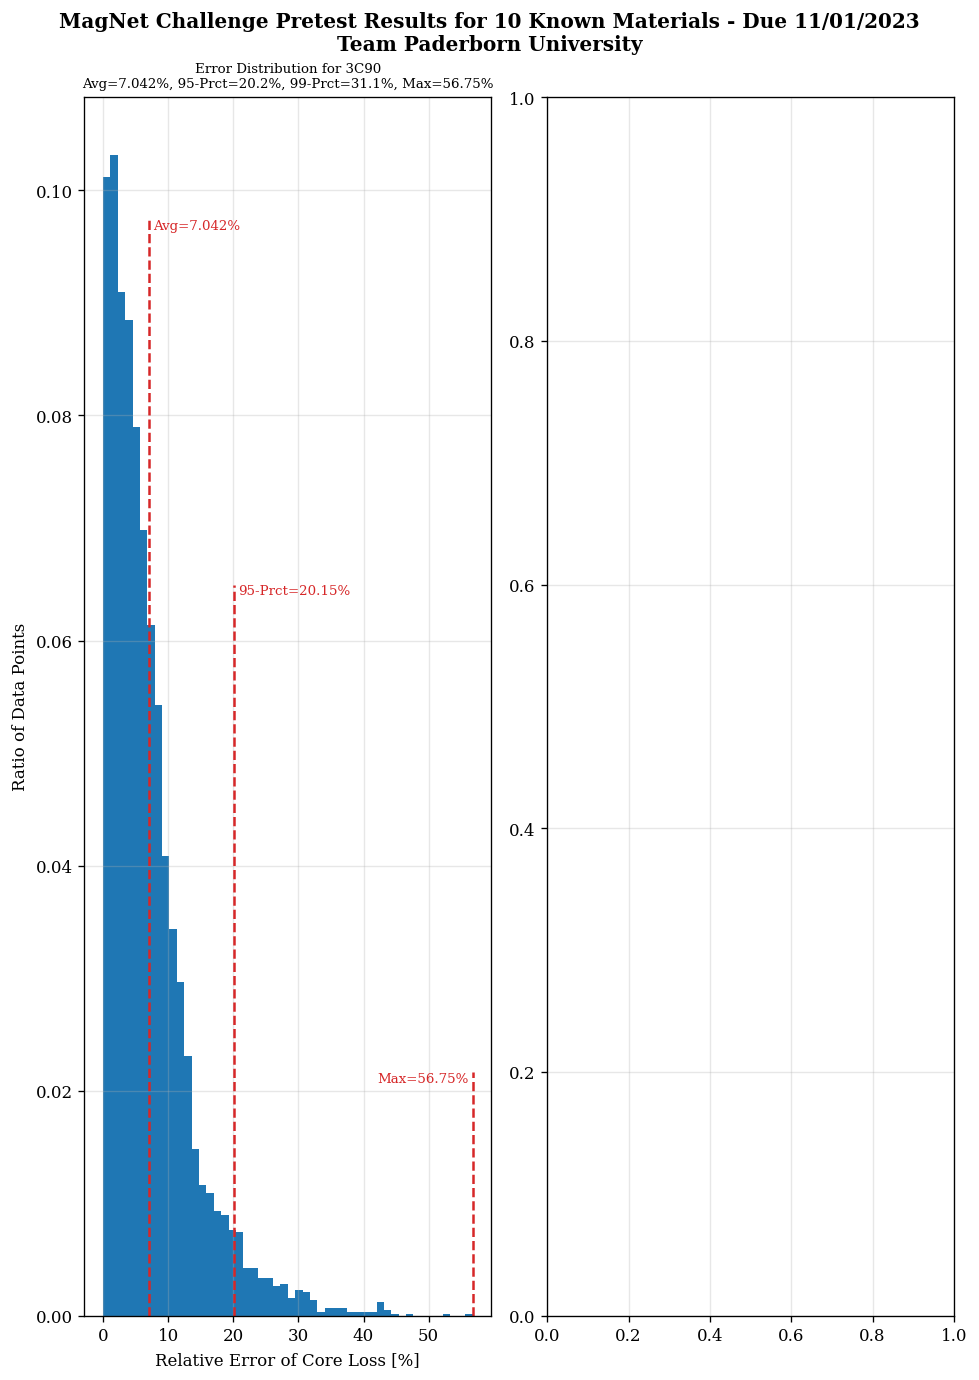

In [30]:
fig = visualize_rel_error_report(h_pred_val, ds)

# Load up meta info

In [8]:
pd.read_csv(TRIALS_CSV_PATH)

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date
0,6a78a,3C90,0fca07ed,0,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:16:06,2023-11-25 18:16:07
1,6a78a,3C90,9143cfd3,1,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:16:06,2023-11-25 18:16:07
2,6a78a,3C90,4f2d9a57,2,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:16:06,2023-11-25 18:16:07
3,6a78a,78,23f50686,0,0,1.000000,1.000000,1.000000,146972.188002,2023-11-25 18:16:07,2023-11-25 18:16:07
4,6a78a,78,dd161fb8,1,0,1.000000,1.000000,1.000000,146972.188002,2023-11-25 18:16:07,2023-11-25 18:16:07
5,6a78a,78,0af8cec9,2,0,1.000000,1.000000,1.000000,146972.188002,2023-11-25 18:16:07,2023-11-25 18:16:07
6,98eec,3C90,cdd0f337,0,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:32:44,2023-11-25 18:32:45
7,98eec,3C90,2944548f,1,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:32:44,2023-11-25 18:32:45
8,98eec,3C90,912dcde1,2,0,1.000000,1.000000,1.000000,32432.128782,2023-11-25 18:32:44,2023-11-25 18:32:45
9,98eec,78,4a2c3423,0,0,1.000000,1.000000,1.000000,146972.188002,2023-11-25 18:32:44,2023-11-25 18:32:45
